In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
        # print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("./rice-leaf-diseases-dataset")

# print("Path to dataset files:", path)

In [1]:
print("hello")
import sys
print(sys.version)


hello
3.10.2 (tags/v3.10.2:a58ebcc, Jan 17 2022, 14:12:15) [MSC v.1929 64 bit (AMD64)]


In [2]:
# ! pip install tensorflow-model-optimization
# ! pip install vitis-ai-tensorflow
# ! pip install tf-keras

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50, VGG16, MobileNetV2, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries
from tensorflow.keras.applications.resnet50 import preprocess_input
from sklearn.metrics import confusion_matrix
# import tensorflow_model_optimization as tfmot
# from tensorflow_model_optimization import sparsity
# import tf_keras as keras
import numpy as np
import time
import os
import tempfile
import zipfile
from collections import Counter


!pip install seaborn
import seaborn as sns


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# dataset_path = '/kaggle/input/rice-leaf-diseases-dataset/rice leaf diseases dataset/'
dataset_path="./rice leaf diseases dataset"
dataset_path_raw = r"C:\Users\MSC04\Downloads\riceLeafDataset_9_class\Rice_Leaf_Diease\Rice_Leaf_Diease\train"
dataset_path_val_raw = r"C:\Users\MSC04\Downloads\riceLeafDataset_9_class\Rice_Leaf_Diease\Rice_Leaf_Diease\test"

print(dataset_path)

./rice leaf diseases dataset


In [5]:
# Set parameters
BATCH_SIZE = 128
IMG_SIZE = (224, 224)  # Standard for pre-trained models
EPOCHS = 2

In [6]:
# Load dataset
train_ds = image_dataset_from_directory(
    dataset_path,  # Replace with your dataset directory
    validation_split=0.3,
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = image_dataset_from_directory(
    dataset_path,  # Replace with your dataset directory
    validation_split=0.3,
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

check_dataset_train = image_dataset_from_directory(
    dataset_path_raw,  # Replace with your dataset directory
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

check_dataset_val = image_dataset_from_directory(
    dataset_path_val_raw,  # Replace with your dataset directory
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)


# Get class names
class_labels = train_ds.class_names

Found 17377 files belonging to 11 classes.
Using 12164 files for training.
Found 17377 files belonging to 11 classes.
Using 5213 files for validation.
Found 15023 files belonging to 10 classes.
Found 3422 files belonging to 10 classes.


In [8]:
print(class_labels)
y_true = np.concatenate([y for x, y in val_ds])
print(y_true.shape)

['Bacterialblight', 'Brownspot', 'Healthy', 'Leafsmut', 'bacterial_leaf_blight', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']
(5625,)


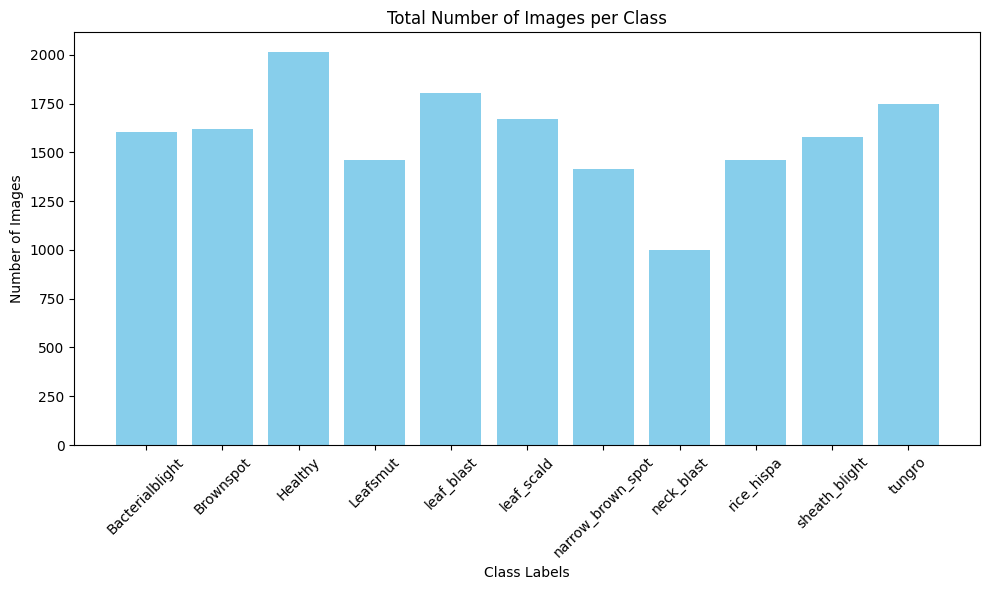

Bacterialblight: 1604 images
Brownspot: 1621 images
Healthy: 2014 images
Leafsmut: 1463 images
leaf_blast: 1805 images
leaf_scald: 1670 images
narrow_brown_spot: 1416 images
neck_blast: 1000 images
rice_hispa: 1461 images
sheath_blight: 1578 images
tungro: 1745 images


In [7]:
import matplotlib.pyplot as plt
from collections import defaultdict
import tensorflow as tf

# Step 1: Count samples per class in both train and val datasets
def count_class_samples(dataset, class_names):
    class_counts = defaultdict(int)
    for images, labels in dataset:
        for label in labels.numpy():
            class_counts[class_names[label]] += 1
    return class_counts

# Get counts
train_counts = count_class_samples(train_ds, class_labels)
val_counts = count_class_samples(val_ds, class_labels)

# Combine counts from train and validation sets
total_counts = {label: train_counts.get(label, 0) + val_counts.get(label, 0) for label in class_labels}

# Step 2: Plotting
plt.figure(figsize=(10, 6))
plt.bar(total_counts.keys(), total_counts.values(), color='skyblue')
plt.xlabel('Class Labels')
plt.ylabel('Number of Images')
plt.title('Total Number of Images per Class')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Optional: Print class-wise counts
for label in class_labels:
    print(f"{label}: {total_counts[label]} images")


In [8]:
check_class_labels = check_dataset_val.class_names
check_train_counts = count_class_samples(check_dataset_train,check_class_labels)
check_val_counts = count_class_samples(check_dataset_val,check_class_labels)

check_total_counts = {label: check_train_counts.get(label, 0) + check_val_counts.get(label, 0) for label in check_class_labels}

for label in check_class_labels:
    print(f"{label}: {check_total_counts[label]} images")

Neck_Blast: 1708 images
Rice Hispa: 1705 images
Sheath Blight: 1779 images
Tungro: 2111 images
bacterial_leaf_blight: 2046 images
brown_spot: 1796 images
healthy: 1391 images
leaf_blast: 1823 images
leaf_scald: 1964 images
narrow_brown_spot: 2122 images


## Show Sample Images

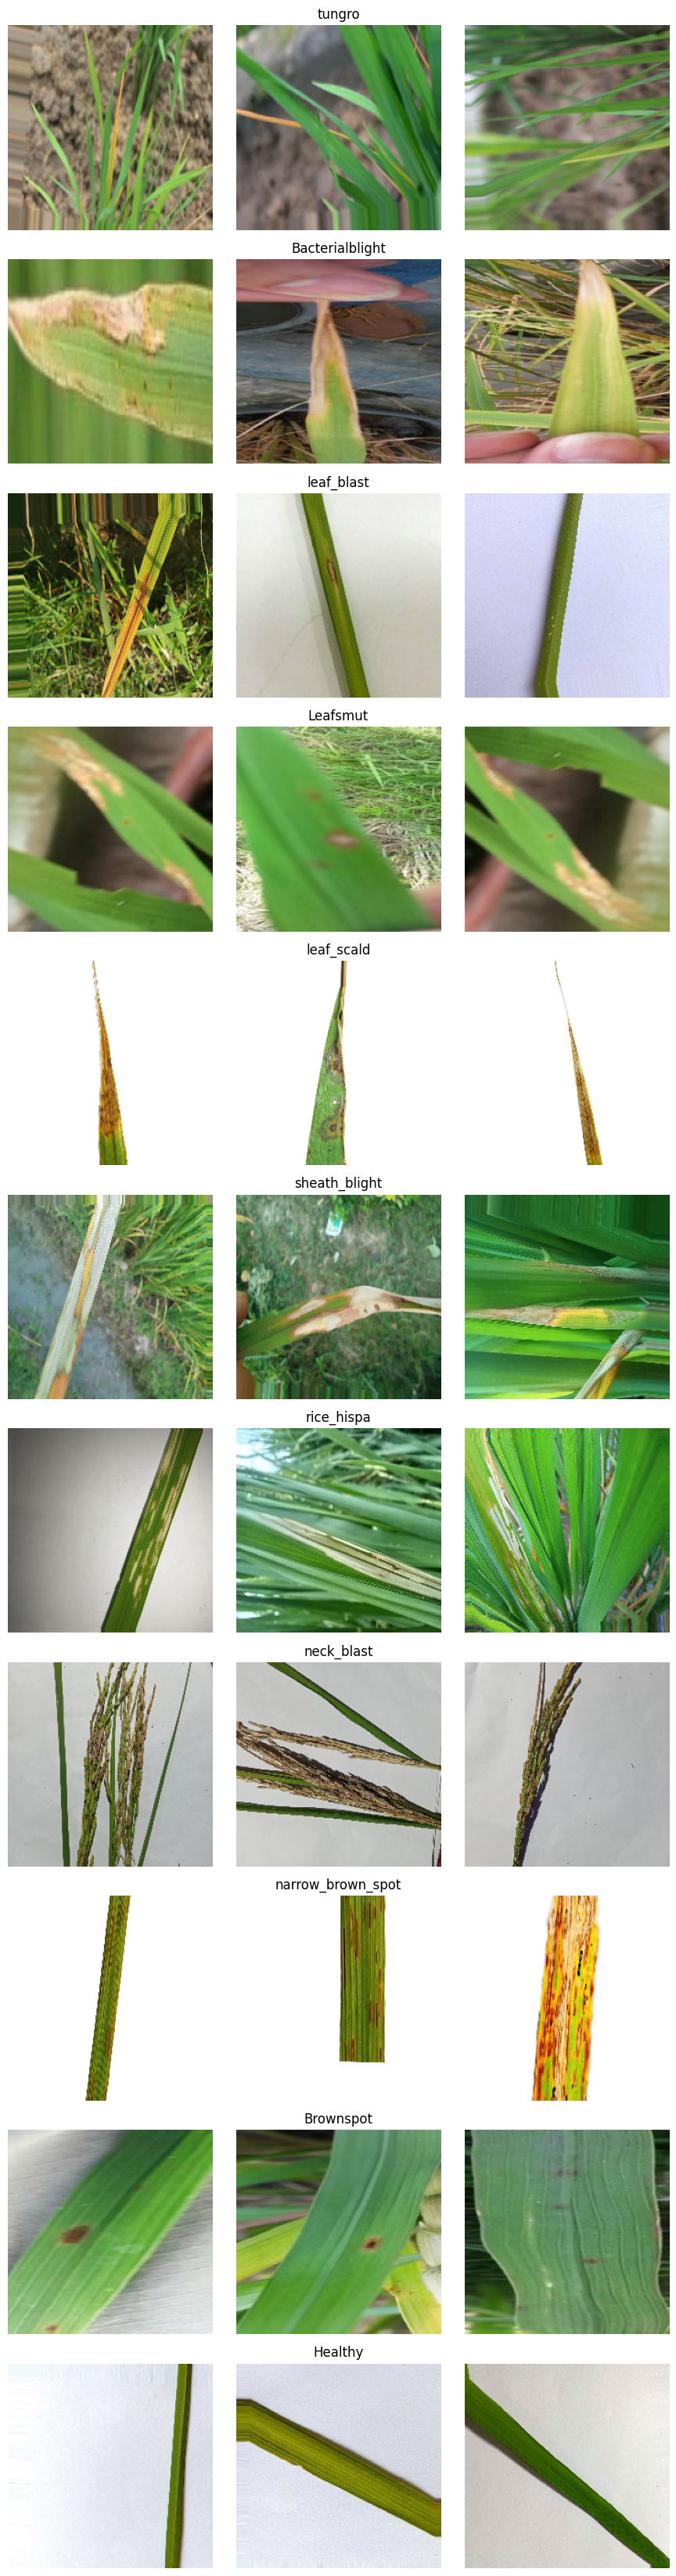

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

# Define a dictionary to store up to 3 images per class
sample_images = {}
num_samples_per_class = 3

# Iterate through the dataset and collect images
for images, labels in train_ds.unbatch():
    label = int(labels.numpy())
    class_name = train_ds.class_names[label]

    if class_name not in sample_images:
        sample_images[class_name] = []

    if len(sample_images[class_name]) < num_samples_per_class:
        sample_images[class_name].append(images.numpy())

    # Stop if we have collected enough samples for all classes
    if all(len(v) == num_samples_per_class for v in sample_images.values()):
        break

# Plotting
num_classes = len(sample_images)
fig, axs = plt.subplots(num_classes, num_samples_per_class, figsize=(num_samples_per_class * 3, num_classes * 3))

for row, (class_name, images) in enumerate(sample_images.items()):
    for col in range(num_samples_per_class):
        ax = axs[row, col] if num_classes > 1 else axs[col]
        ax.imshow(images[col].astype("uint8"))
        ax.axis("off")
        if col == 1:
            ax.set_title(class_name, fontsize=12)

plt.tight_layout()
plt.show()


# Custom Model with Random forrest inclusion

In [10]:
# # Function to prune the model
# def prune_model(model):
#     pruning_params = {
#         'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
#     }
#     return tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

# # Function to quantize the model
# def quantize_model(model):
#     converter = tf.lite.TFLiteConverter.from_keras_model(model)
#     converter.optimizations = [tf.lite.Optimize.DEFAULT]
#     return converter.convert()


In [11]:
# # Function to measure model size
# def get_model_size(model, model_name):
#     model.save(f"{model_name}_temp.h5")
#     size = os.path.getsize(f"{model_name}_temp.h5") / (1024 * 1024)  # Convert bytes to MB
#     os.remove(f"{model_name}_temp.h5")
#     return size

# # Function to measure inference time
# def measure_inference_time(model, test_sample, n_runs=100):
#     start_time = time.time()
#     for _ in range(n_runs):
#         model.predict(test_sample)
#     avg_time = (time.time() - start_time) / n_runs
#     return avg_time


In [12]:
# Function to compute confusion matrix
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

In [13]:
# # Function to create model
# def create_model(base_model):
#     # Freeze the base model layers to prevent training
#     base_model.trainable = False

#     # Add new layers on top
#     x = base_model.output
#     x = GlobalAveragePooling2D()(x)
#     x = Dense(128, activation='relu')(x)
#     predictions = Dense(12, activation='softmax')(x)  # 4 classes

#     # Create final model
#     model = Model(inputs=base_model.input, outputs=predictions)
#     return model

In [14]:
# Function to count samples in a dataset
def count_samples_per_class(dataset, class_labels):
    class_counts = Counter()
    for images, labels in dataset:
        class_counts.update(labels.numpy())  # Convert tensor to numpy array and update counter
    return {class_labels[i]: count for i, count in class_counts.items()}

# Count samples in training and validation datasets
train_class_counts = count_samples_per_class(train_ds, class_labels)
val_class_counts = count_samples_per_class(val_ds, class_labels)

print("Training class distribution:", train_class_counts)
print("Validation class distribution:", val_class_counts)

Training class distribution: {'sheath_blight': 1119, 'leaf_scald': 1180, 'Healthy': 1375, 'Leafsmut': 1030, 'Bacterialblight': 1134, 'narrow_brown_spot': 986, 'Brownspot': 1149, 'tungro': 1188, 'neck_blast': 696, 'leaf_blast': 1276, 'rice_hispa': 1027, 'bacterial_leaf_blight': 965}
Validation class distribution: {'Healthy': 639, 'narrow_brown_spot': 430, 'Bacterialblight': 470, 'leaf_blast': 525, 'Brownspot': 471, 'sheath_blight': 459, 'leaf_scald': 490, 'tungro': 552, 'rice_hispa': 434, 'Leafsmut': 430, 'bacterial_leaf_blight': 421, 'neck_blast': 304}


### models

In [15]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


In [16]:
# List of pre-trained models
models = {
    # "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    # "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    # "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    # "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
}
performance_dict = {model_name: {"before": {}, "after": {}} for model_name in models}
# Dictionary to store performance metrics
performance_metrics = {model_name: {"size": {}, "inference_time": {}, "accuracy": {}} for model_name in models}
# Dictionary to store history for plotting
history_dict = {}

## TEST

C:\Users\MSC04\AppData\Local\Temp\ipykernel_20584\1010827096.py:62: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


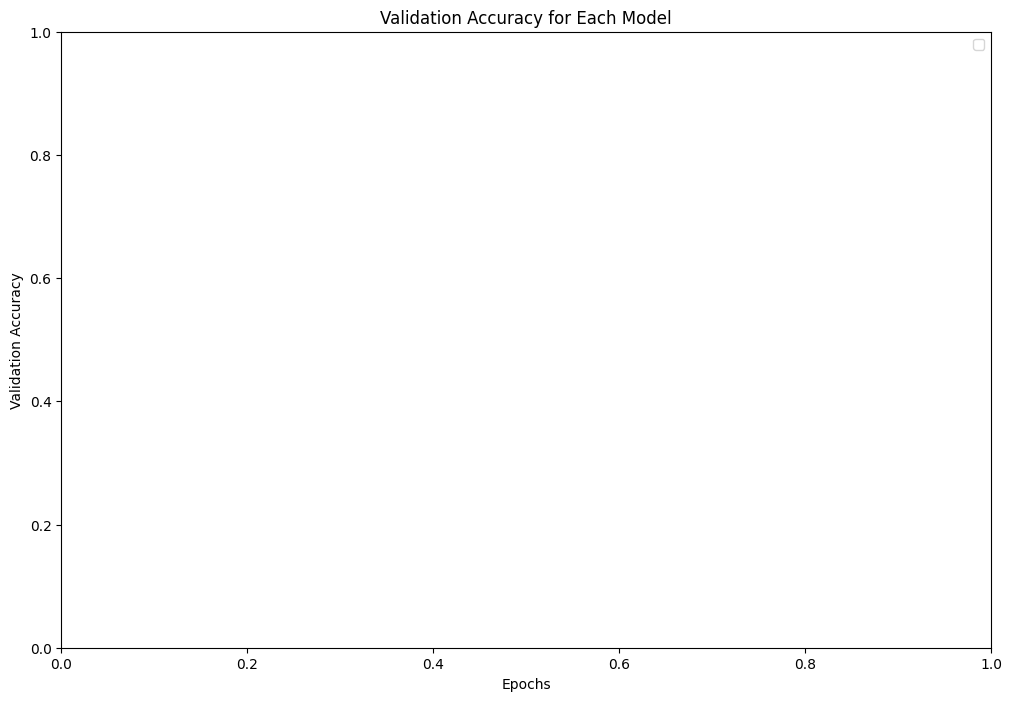

In [17]:
for name, base_model in models.items():
    print(f"Optimizing model: {name}")
    
    # Load and create the model
    model = create_model(base_model)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
    history_dict[name] = history.history
    
    # Save the unoptimized model's size, inference time, and accuracy
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    model.save(temp_file.name)
    model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
    start_time = time.time()
    _, accuracy = model.evaluate(val_ds)
    inference_time = time.time() - start_time
    performance_metrics[name]['size']['original'] = model_size
    performance_metrics[name]['inference_time']['original'] = inference_time
    performance_metrics[name]['accuracy']['original'] = accuracy

    
    # Apply pruning
    # pruned_model = prune_model(model)
    # pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    # pruned_history = pruned_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
    # pruned_model_stripped = tfmot.sparsity.keras.strip_pruning(pruned_model)
    
    # Save the pruned model's size, inference time, and accuracy
    # temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    # pruned_model_stripped.save(temp_file.name)
    # pruned_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)
    # start_time = time.time()
    # _, pruned_accuracy = pruned_model_stripped.evaluate(val_ds)
    # pruned_inference_time = time.time() - start_time
    # performance_metrics[name]['size']['pruned'] = pruned_model_size
    # performance_metrics[name]['inference_time']['pruned'] = pruned_inference_time
    # performance_metrics[name]['accuracy']['pruned'] = pruned_accuracy

    # Collect true labels
    y_true = np.concatenate([y for x, y in val_ds])

    # Get predictions
    y_pred_prob = model.predict(val_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)


    # Code to get confusion matrices
    # Plot confusion matrix
    # plot_confusion_matrix(y_true, y_pred, name)
    

# Plot accuracy for each model
plt.figure(figsize=(12, 8))
for model_name, history in history_dict.items():
    plt.plot(history['val_accuracy'], label=f"{model_name} (Original)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy for Each Model")
plt.legend()
plt.show()


C:\Users\MSC04\AppData\Local\Temp\ipykernel_20584\1390344113.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


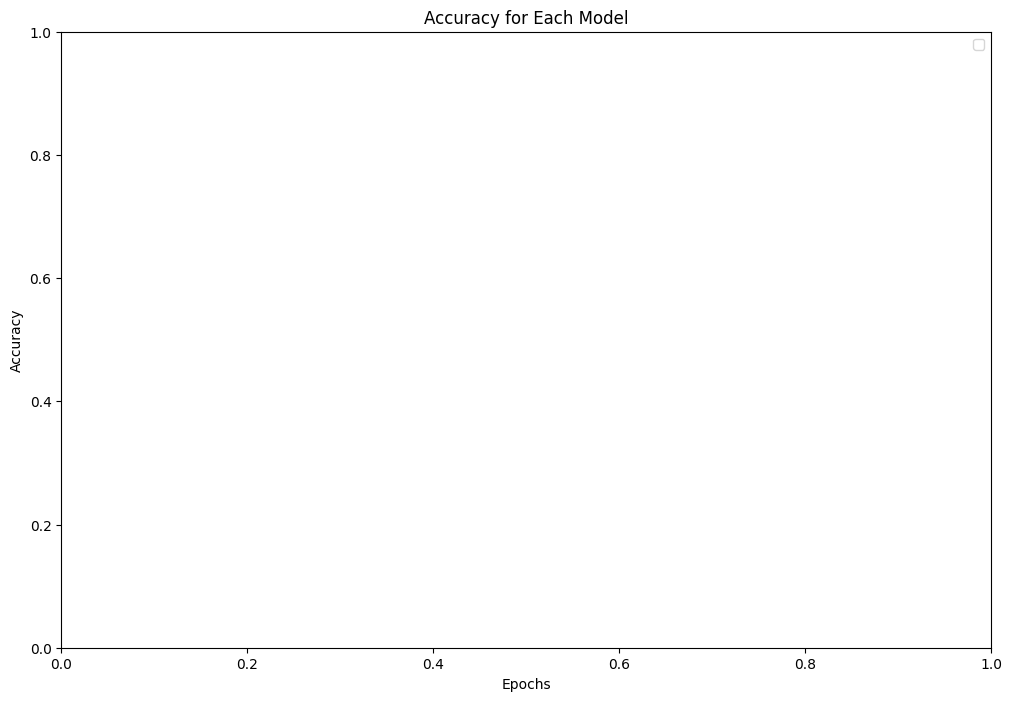

In [18]:
# print(history_dict.items())

plt.figure(figsize=(12, 8))
for model_name, history in history_dict.items():
    plt.plot(history['accuracy'], label=f"{model_name} (Original)")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy for Each Model")
plt.legend()
plt.show()

In [19]:
performance_comparison = {}

In [20]:
labels = ["Size (MB)", "Latency (s)"]
for model_name, metrics in performance_comparison.items():
    before = [metrics["Original Size (MB)"], metrics["Original Latency (s)"]]
    after = [metrics["Optimized Size (MB)"], metrics["Optimized Latency (s)"]]
    
    x = range(len(labels))
    plt.figure(figsize=(8, 6))
    plt.bar(x, before, width=0.4, label="Before Optimization", align='center')
    plt.bar([p + 0.4 for p in x], after, width=0.4, label="After Optimization", align='center')
    plt.xticks([p + 0.2 for p in x], labels)
    plt.title(f"Performance Comparison for {model_name}")
    plt.ylabel("Metrics")
    plt.legend()
    plt.show()


In [21]:



# Train each model and save the accuracy history
# performance_metrics = {model_name: {"size": {}, "inference_time": {}} for model_name in models}

# for name, base_model in models.items():
#     print(f"Optimizing model: {name}")
    
#     # Load and create the model
#     model = create_model(base_model)
#     model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     # Train the model
#     early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#     model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])

#     # Save the unoptimized model's size and inference time
#     temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
#     model.save(temp_file.name)
#     model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
#     start_time = time.time()
#     _ = model.predict(val_ds)
#     inference_time = time.time() - start_time
#     performance_metrics[name]['size']['original'] = model_size
#     performance_metrics[name]['inference_time']['original'] = inference_time
    
    # Apply pruning
    # Apply pruning correctly before training
#     pruned_model = prune_model(model)
#     pruned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
#     # Train the pruned model
#     early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#     pruned_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
#     pruned_model_stripped = tfmot.sparsity.keras.strip_pruning(pruned_model)


    
#     temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
#     pruned_model_stripped.save(temp_file.name)
#     pruned_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)
#     start_time = time.time()
#     _ = pruned_model_stripped.predict(val_ds)
#     pruned_inference_time = time.time() - start_time
#     performance_metrics[name]['size']['pruned'] = pruned_model_size
#     performance_metrics[name]['inference_time']['pruned'] = pruned_inference_time
    
#     # Apply quantization
#     quantized_model = quantize_model(pruned_model_stripped)
#     quantized_file = tempfile.NamedTemporaryFile(delete=False, suffix=".tflite")
#     with open(quantized_file.name, 'wb') as f:
#         f.write(quantized_model)
#     quantized_model_size = os.path.getsize(quantized_file.name) / (1024 * 1024)
    
#     interpreter = tf.lite.Interpreter(model_path=quantized_file.name)
#     interpreter.allocate_tensors()
#     input_details = interpreter.get_input_details()
#     output_details = interpreter.get_output_details()
    
#     start_time = time.time()
#     for batch in val_ds.take(1):
#         inputs = batch[0].numpy()
#         interpreter.set_tensor(input_details[0]['index'], inputs)
#         interpreter.invoke()
#         outputs = interpreter.get_tensor(output_details[0]['index'])
#     quantized_inference_time = time.time() - start_time

#     performance_metrics[name]['size']['quantized'] = quantized_model_size
#     performance_metrics[name]['inference_time']['quantized'] = quantized_inference_time

# # Print results
# print("\nPerformance Metrics:")
# for model_name, metrics in performance_metrics.items():
#     print(f"\nModel: {model_name}")
#     print("Size (MB):", metrics['size'])
#     print("Inference Time (s):", metrics['inference_time'])


In [22]:
# for i,j in val_ds.take(0):
#     print(i)
#     print(j)


## LIME IMPLEMENTATION

In [23]:
# import numpy as np
# from lime import lime_image
# from skimage.segmentation import mark_boundaries
# import matplotlib.pyplot as plt

# # Load a single image for explanation
# image_batch, label_batch = next(iter(val_ds))  # Fetch a batch of images from the validation dataset
# img = image_batch[0].numpy().astype('double')  # Pick the first image and convert it to numpy array
# true_label = label_batch[0].numpy()


# # LIME explainer for image
# explainer = lime_image.LimeImageExplainer()

# # Prediction function: Preprocess the image and use the model to predict
# def predict_fn(images):
#     images = np.array(images)
#     preds = model.predict(images)
#     return preds

# # Explain the prediction for the chosen image
# explanation = explainer.explain_instance(
#     img, 
#     predict_fn, 
#     top_labels=4,  # Number of top labels to consider
#     hide_color=0, 
#     num_samples=1000  # Number of perturbed samples to generate
# )




In [24]:
# # Visualize explanation
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Positive regions for the top predicted label
# temp, mask = explanation.get_image_and_mask(
#     label=explanation.top_labels[0],  # Top predicted class
#     positive_only=True,
#     num_features=4, 
#     hide_rest=True
# )

# # Display original image
# axes[0].imshow(img / 255.0)  # Normalize image
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# # Display explanation with LIME highlighting regions
# axes[1].imshow(mark_boundaries(temp / 255.0, mask))  # Highlighted regions
# axes[1].set_title("LIME Explanation")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()

## Grad Cam Implementation

In [25]:
# import tensorflow as tf
# import numpy as np
# import matplotlib.pyplot as plt
# import cv2

# # Function to compute Grad-CAM
# def compute_gradcam(model, img_array, layer_name, class_index):
#     # Create a model that maps the input image to the activations of the specified layer and predictions
#     # grad_model = tf.keras.models.Model(
#     #     inputs=[model.inputs],
#     #     outputs=[model.get_layer(layer_name).output, model.output]
#     # )

#     grad_model = tf.keras.models.Model(
#     inputs=model.input,  # Use model.input or model.inputs directly
#     outputs=[model.get_layer(layer_name).output, model.output]
#     )

#     # Compute gradients
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(tf.expand_dims(img_array, axis=0))
#         loss = predictions[:, class_index]  # Get the score for the predicted class
    
#     # Gradients of the loss w.r.t the convolutional layer output
#     grads = tape.gradient(loss, conv_outputs)
#     output = conv_outputs[0]
#     grads = grads[0]

#     # Compute the weights for Grad-CAM
#     weights = tf.reduce_mean(grads, axis=(0, 1))  # Global average pooling of gradients
#     cam = np.dot(output, weights)  # Weighted sum of feature maps

#     # Apply ReLU to the Grad-CAM
#     cam = np.maximum(cam, 0)

#     # Normalize the Grad-CAM to [0, 1]
#     cam = cam / np.max(cam)
#     return cam

# # Choose a convolutional layer to explain (last conv layer)
# last_conv_layer = "conv5_block3_out"  # Replace with your model's last convolutional layer

# # Load a single image for Grad-CAM
# image_batch, label_batch = next(iter(val_ds))  # Fetch a batch of images
# img = image_batch[0].numpy()  # Select the first image
# img_resized = img / 255.0  # Normalize for visualization
# true_label = label_batch[0].numpy()

# # Get the predicted class
# preds = model.predict(np.expand_dims(img, axis=0))
# predicted_class = np.argmax(preds[0])

# # Compute Grad-CAM
# gradcam = compute_gradcam(model, img, last_conv_layer, predicted_class)

# # Resize Grad-CAM to match the input image
# gradcam_resized = cv2.resize(gradcam, (img.shape[1], img.shape[0]))
# heatmap = np.uint8(255 * gradcam_resized)

# # Overlay Grad-CAM heatmap on the original image
# jet = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
# overlay = cv2.addWeighted(cv2.cvtColor(img.astype('uint8'), cv2.COLOR_RGB2BGR), 0.6, jet, 0.4, 0)

# # Visualize Grad-CAM
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# # Original Image
# axes[0].imshow(img_resized)
# axes[0].set_title("Original Image")
# axes[0].axis('off')

# # Grad-CAM Heatmap
# axes[1].imshow(overlay[:, :, ::-1])  # Convert BGR back to RGB
# axes[1].set_title("Grad-CAM Heatmap")
# axes[1].axis('off')

# plt.tight_layout()
# plt.show()


In [26]:
# plt.figure(figsize=(24, 8))  # Adjust the figure size to accommodate two plots side by side

# # First subplot: Training Accuracy
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['accuracy'], label=name)
# plt.title('Model Training Accuracy Comparison')
# plt.ylabel('Training Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# # Second subplot: Validation Accuracy
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['val_accuracy'], label=name)
# plt.title('Model Validation Accuracy Comparison')
# plt.ylabel('Validation Accuracy')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# plt.show()

In [27]:
# print((history.__dict__))

In [28]:
# plt.figure(figsize=(30, 8))  # Adjust the figure size to accommodate two plots side by side

# # First subplot: Training Accuracy
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['loss'], label=name)
# plt.title('Model Training loss Comparison')
# plt.ylabel('Training loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# # Second subplot: Validation Accuracy
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
# for name, history in history_dict.items():
#     plt.plot(history.history['val_loss'], label=name)
# plt.title('Model Validation Loss Comparison')
# plt.ylabel('Validation Loss')
# plt.xlabel('Epoch')
# plt.legend(loc='upper left')

# plt.show()

In [29]:
# selected_model = models['ResNet50']  # Example: you can choose another model
# for images, labels in val_ds.take(1):  # Take a single batch from validation data
#     image = images[0].numpy()  # Get the first image in the batch
#     label = labels[0].numpy()  # Get the corresponding label

In [30]:
# def get_gradcam_heatmap(model, img_array, last_conv_layer_name):
#     # Define the model for Grad-CAM
#     grad_model = tf.keras.models.Model(
#         inputs=model.input,
#         outputs=[model.get_layer(last_conv_layer_name).output, model.output]
#     )

#     # Record the gradients of the predicted class
#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_array)
#         top_class_idx = tf.argmax(predictions[0])
#         top_class_output = predictions[:, top_class_idx]

#     # Compute the gradients
#     grads = tape.gradient(top_class_output, conv_outputs)

#     # Pool the gradients across the spatial dimensions
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     # Expand dimensions of pooled_grads to match conv_outputs
#     pooled_grads = tf.expand_dims(tf.expand_dims(pooled_grads, 0), 0)

#     # Element-wise multiplication
#     conv_outputs = conv_outputs[0]
#     conv_outputs = conv_outputs * pooled_grads

#     # Compute the heatmap
#     heatmap = tf.reduce_mean(conv_outputs, axis=-1)
#     heatmap = np.maximum(heatmap, 0) / (np.max(heatmap) + 1e-7)  # Normalize the heatmap
#     return heatmap.numpy()




# # Display Grad-CAM
# def display_gradcam(model, img_path, last_conv_layer_name):
#     img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
#     img_array = tf.keras.preprocessing.image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)
#     img_array = preprocess_input(img_array)

#     heatmap = get_gradcam_heatmap(model, img_array, last_conv_layer_name)

#     # Resize heatmap to match the original image
#     heatmap = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
#     heatmap = np.uint8(255 * heatmap)

#     # Apply colormap to heatmap
#     heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

#     # Superimpose the heatmap on the original image
#     superimposed_img = heatmap * 0.4 + img_array[0]
#     superimposed_img = np.uint8(superimposed_img)

#     # Display the image with Grad-CAM
#     plt.figure(figsize=(10, 10))
#     plt.subplot(1, 2, 1)
#     plt.title("Original Image")
#     plt.imshow(img / 255.0)
#     plt.axis('off')

#     plt.subplot(1, 2, 2)
#     plt.title("Grad-CAM")
#     plt.imshow(superimposed_img)
#     plt.axis('off')
#     plt.show()
    
# sample_image_path = "/kaggle/input/rice-leaf-diseases-dataset/rice leaf diseases dataset/Brownspot/Brownspot (1).jpg"

# selected_model = models["ResNet50"]
# last_conv_layer_name = "conv5_block3_out"  # Ch
# display_gradcam(selected_model, sample_image_path, last_conv_layer_name)


In [31]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [32]:
# def measure_inference_time(model, dataset):
#     start_time = time.time()
#     for images, _ in dataset.take(10):
#         _ = model.predict(images)
#     return (time.time() - start_time) / 10

# original_inference_time = measure_inference_time(model, val_ds)

In [33]:
# ! pip install torch torchvision transformers datasets timm


In [34]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from transformers import DeiTForImageClassification, BeitForImageClassification, AutoImageProcessor
import torch.nn as nn
import torch.optim as optim


In [35]:

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define dataset path
dataset_path ="./rice leaf diseases dataset"

# Define transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images for model input
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize([0.5], [0.5])  # Normalize images
])

# Load dataset
full_dataset = ImageFolder(root=dataset_path, transform=transform)
num_classes = len(full_dataset.classes)
print("NUM OF CLASS ",num_classes)
# Split into training and validation sets (70% train, 30% val)
train_size = int(0.7 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Data loaders
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)



NUM OF CLASS  12


In [36]:
# import torch
# import time
# import os
# from torch import nn, optim
# from transformers import DeiTForImageClassification, BeitForImageClassification, SwinForImageClassification

# # Function to get model size
# def get_model_size(model, filename="temp_model.pth"):
#     torch.save(model.state_dict(), filename)
#     size_mb = os.path.getsize(filename) / (1024 * 1024)  # Convert to MB
#     os.remove(filename)  # Clean up file
#     return size_mb

# # Function to measure inference time
# def measure_inference_time(model, sample_input, num_runs=100):
#     model.eval()
#     with torch.no_grad():
#         start_time = time.time()
#         for _ in range(num_runs):
#             _ = model(sample_input).logits
#         end_time = time.time()
#     return (end_time - start_time) / num_runs  # Average time per inference

# # Apply quantization to shrink the model
# def quantize_model(model):
#     model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
#     return model

# # Train and validate models
# # Function to calculate accuracy
# def calculate_accuracy(model, data_loader):
#     model.eval()
#     correct = 0
#     total = 0
#     with torch.no_grad():
#         for images, labels in data_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images).logits
#             _, predicted = torch.max(outputs, 1)
#             correct += (predicted == labels).sum().item()
#             total += labels.size(0)
#     return correct / total


# # Train and validate models
# def train_and_validate_model(model, optimizer, num_epochs=20):
#     for epoch in range(num_epochs):
#         model.train()
#         correct_train = 0
#         total_train = 0
#         running_loss = 0.0
        
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images).logits
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
            
#             # Compute training accuracy
#             _, predicted = torch.max(outputs, 1)
#             correct_train += (predicted == labels).sum().item()
#             total_train += labels.size(0)
#             running_loss += loss.item()

#         train_accuracy = correct_train / total_train
#         val_accuracy = calculate_accuracy(model, val_loader)
#         avg_loss = running_loss / len(train_loader)
        
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, "
#               f"Training Accuracy: {train_accuracy:.4f}, Validation Accuracy: {val_accuracy:.4f}")

#     # Output model size after training
#     size_before = get_model_size(model)
#     print(f"Model size before quantization: {size_before:.2f} MB")
    
#     # Quantize model
#     model = quantize_model(model)
#     size_after = get_model_size(model)
#     print(f"Model size after quantization: {size_after:.2f} MB")
    
#     # Measure inference time
#     sample_input = torch.randn(1, 3, 224, 224).to(device)
#     avg_inference_time = measure_inference_time(model, sample_input)
#     print(f"Average inference time: {avg_inference_time:.6f} seconds")
    
#     return model


# # Load and process models
# deit_model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", num_labels=num_classes).to(device)
# beit_model = BeitForImageClassification.from_pretrained("microsoft/beit-base-patch16-224", num_labels=num_classes, ignore_mismatched_sizes=True).to(device)
# swin_model = SwinForImageClassification.from_pretrained("microsoft/swin-base-patch4-window7-224", num_labels=num_classes,  ignore_mismatched_sizes=True).to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer_deit = optim.AdamW(deit_model.parameters(), lr=2e-5)
# optimizer_beit = optim.AdamW(beit_model.parameters(), lr=2e-5)
# optimizer_swin = optim.AdamW(swin_model.parameters(), lr=2e-5)


# #Num of EPOHCS -
# epochs = 2
# print("Training and validating DEiT...")
# deit_model = train_and_validate_model(deit_model, optimizer_deit,epochs)

# print("Training and validating BEiT...")
# beit_model = train_and_validate_model(beit_model, optimizer_beit,epochs)

# print("Training and validating Swin Transformer V2...")
# swin_model = train_and_validate_model(swin_model, optimizer_swin,epochs)


# TEST Model Shrinkage

In [37]:
# Install the TensorFlow Model Optimization Toolkit
!pip install -q tensorflow-model-optimization

You should consider upgrading via the 'C:\Users\MSC04\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [38]:
import gc
# Import necessary libraries
import tensorflow as tf
import tempfile
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import VGG16, MobileNetV2, EfficientNetB0, ResNet50
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

gc.collect()
tf.keras.backend.clear_session()

BATCH_SIZE = 64
IMG_SIZE = (224, 224)  # Standard for pre-trained models
EPOCHS = 14
NUM_CLASSES =12




In [ ]:


# Function to create model
def create_model(base_model):
    x = base_model.output
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.5)(x)  # Add Dropout layer
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.0001))(x)  # L2 Regularization
    x = tf.keras.layers.Dropout(0.5)(x)  # Another Dropout layer
    predictions = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)
    model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
    return model

# Quantization function (post-training quantization)
def apply_quantization(model):
    # Convert model to TensorFlow Lite model
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    # Apply quantization
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_model = converter.convert()
    return quantized_model

# Function to evaluate TFLite model
def evaluate_tflite_model(tflite_model, dataset):
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]
    
    predictions = []
    test_labels = []
    
    for images, labels in dataset:
        for img, label in zip(images.numpy(), labels.numpy()):
            # Preprocess the image to required size and cast
            img = np.expand_dims(img, axis=0).astype(np.float32)
            
            interpreter.set_tensor(input_index, img)
            interpreter.invoke()
            
            # Get the result and postprocess to get the predicted class
            output = interpreter.get_tensor(output_index)
            predictions.append(output[0])
            test_labels.append(label)
    
    predictions = np.array(predictions)
    test_labels = np.array(test_labels)
    predicted_classes = np.argmax(predictions, axis=1)
    
    # Calculate accuracy
    acc = np.sum(predicted_classes == test_labels) / len(test_labels)
    return acc, predictions

# List of pre-trained models
models = {
    # "VGG16": VGG16(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "MobileNetV2": MobileNetV2(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "EfficientNetB0": EfficientNetB0(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
    "ResNet50": ResNet50(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,)),
}

# Dictionary to store performance metrics
performance_metrics = {model_name: {
    "size": {},
    "inference_time": {},
    "accuracy": {}
} for model_name in models}

# Dictionary to store history for plotting
history_dict = {}

for name, base_model in models.items():
    print(f"\n{'-'*50}\nOptimizing model: {name}\n{'-'*50}")
    
    # Load and create the model
    print("Creating and training original model...")
    model = create_model(base_model)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    # Train the model
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stop])
    history_dict[name] = {'original': history.history}
    
    # Save the unoptimized model's size, inference time, and accuracy
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    model.save(temp_file.name)
    original_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
    
    start_time = time.time()
    _, original_accuracy = model.evaluate(val_ds)
    original_inference_time = (time.time() - start_time) / tf.data.experimental.cardinality(val_ds).numpy()  # per batch
    
    performance_metrics[name]['size']['original'] = original_model_size
    performance_metrics[name]['inference_time']['original'] = original_inference_time
    performance_metrics[name]['accuracy']['original'] = original_accuracy
    
    print(f"Original model - Size: {original_model_size:.2f} MB, Accuracy: {original_accuracy:.4f}, Inference time: {original_inference_time*1000:.2f} ms per batch")
    
    # Apply weight clustering (alternative to pruning, using standard Keras)
    print("\nApplying weight clustering...")
    
    # Rather than pruning (which requires tfmot), let's apply a simple weight clustering approach
    # We'll retrain with a smaller model as an approximation
    clustered_model = create_model(base_model)
    # Apply a constraint to the dense layers to simulate clustering effects
    for layer in clustered_model.layers:
        if isinstance(layer, tf.keras.layers.Dense):
            layer.kernel_constraint = tf.keras.constraints.UnitNorm(axis=0)
    
    clustered_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    clustering_history = clustered_model.fit(train_ds, validation_data=val_ds, 
                                     epochs=EPOCHS, callbacks=[early_stop])
    history_dict[name]['clustered'] = clustering_history.history
    
    # Save the clustered model
    temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".h5")
    clustered_model.save(temp_file.name)
    clustered_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
    
    start_time = time.time()
    _, clustered_accuracy = clustered_model.evaluate(val_ds)
    clustered_inference_time = (time.time() - start_time) / tf.data.experimental.cardinality(val_ds).numpy()  # per batch
    
    performance_metrics[name]['size']['clustered'] = clustered_model_size
    performance_metrics[name]['inference_time']['clustered'] = clustered_inference_time
    performance_metrics[name]['accuracy']['clustered'] = clustered_accuracy
    
    print(f"Clustered model - Size: {clustered_model_size:.2f} MB, Accuracy: {clustered_accuracy:.4f}, Inference time: {clustered_inference_time*1000:.2f} ms per batch")
    
    # Apply quantization
    print("\nApplying quantization...")
    try:
        quantized_model = apply_quantization(clustered_model)
        quantized_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        quantized_model_history = quantized_model.fit(train_ds, validation_data=val_ds, 
                                     epochs=EPOCHS, callbacks=[early_stop])
        # Save the quantized model
        temp_file = tempfile.NamedTemporaryFile(delete=False, suffix=".tflite")
        with open(temp_file.name, 'wb') as f:
            f.write(quantized_model)
        quantized_model_size = os.path.getsize(temp_file.name) / (1024 * 1024)  # Convert to MB
        
        # Evaluate quantized model
        start_time = time.time()
        quantized_accuracy, _ = evaluate_tflite_model(quantized_model, val_ds)
        quantized_inference_time = (time.time() - start_time) / tf.data.experimental.cardinality(val_ds).numpy()  # per batch
        
        performance_metrics[name]['size']['quantized'] = quantized_model_size
        performance_metrics[name]['inference_time']['quantized'] = quantized_inference_time
        performance_metrics[name]['accuracy']['quantized'] = quantized_accuracy
        
        print(f"Quantized model - Size: {quantized_model_size:.2f} MB, Accuracy: {quantized_accuracy:.4f}, Inference time: {quantized_inference_time*1000:.2f} ms per batch")
    except Exception as e:
        print(f"Error during quantization: {e}")
        print("Skipping quantization for this model...")
        performance_metrics[name]['size']['quantized'] = None
        performance_metrics[name]['inference_time']['quantized'] = None
        performance_metrics[name]['accuracy']['quantized'] = None

# Plot results
plt.figure(figsize=(15, 10))
plt.suptitle("Model Optimization Results", fontsize=16)

# Plot 1: Model Size Comparison
plt.subplot(2, 2, 1)
model_names = list(performance_metrics.keys())
original_sizes = [performance_metrics[name]['size']['original'] for name in model_names]
clustered_sizes = [performance_metrics[name]['size']['clustered'] for name in model_names]
quantized_sizes = [performance_metrics[name]['size']['quantized'] if performance_metrics[name]['size']['quantized'] is not None else 0 for name in model_names]

x = np.arange(len(model_names))
width = 0.25

plt.bar(x - width, original_sizes, width, label='Original')
plt.bar(x, clustered_sizes, width, label='Clustered')
if any(s > 0 for s in quantized_sizes):
    plt.bar(x + width, quantized_sizes, width, label='Quantized')
plt.ylabel('Model Size (MB)')
plt.title('Model Size Comparison')
plt.xticks(x, model_names)
plt.legend()

# Plot 2: Accuracy Comparison
plt.subplot(2, 2, 2)
original_acc = [performance_metrics[name]['accuracy']['original'] * 100 for name in model_names]
clustered_acc = [performance_metrics[name]['accuracy']['clustered'] * 100 for name in model_names]
quantized_acc = [performance_metrics[name]['accuracy']['quantized'] * 100 if performance_metrics[name]['accuracy']['quantized'] is not None else 0 for name in model_names]

plt.bar(x - width, original_acc, width, label='Original')
plt.bar(x, clustered_acc, width, label='Clustered')
if any(a > 0 for a in quantized_acc):
    plt.bar(x + width, quantized_acc, width, label='Quantized')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Comparison')
plt.xticks(x, model_names)
plt.legend()

# Plot 3: Inference Time Comparison
plt.subplot(2, 2, 3)
original_time = [performance_metrics[name]['inference_time']['original'] * 1000 for name in model_names]  # ms
clustered_time = [performance_metrics[name]['inference_time']['clustered'] * 1000 for name in model_names]  # ms
quantized_time = [performance_metrics[name]['inference_time']['quantized'] * 1000 if performance_metrics[name]['inference_time']['quantized'] is not None else 0 for name in model_names]  # ms

plt.bar(x - width, original_time, width, label='Original')
plt.bar(x, clustered_time, width, label='Clustered')
if any(t > 0 for t in quantized_time):
    plt.bar(x + width, quantized_time, width, label='Quantized')
plt.ylabel('Inference Time per Batch (ms)')
plt.title('Inference Time Comparison')
plt.xticks(x, model_names)
plt.legend()

# Plot 4: Training History for a Selected Model
plt.subplot(2, 2, 4)
for i, name in enumerate(models.keys()):
    if 'original' in history_dict[name]:
        plt.plot(history_dict[name]['original']['val_accuracy'], 
                 label=f"{name} (Original)")
    if 'clustered' in history_dict[name]:
        plt.plot(history_dict[name]['clustered']['val_accuracy'], 
                 linestyle='--', label=f"{name} (Clustered)")
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")
plt.title("Training History")
plt.legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Print summary table
print("\n" + "="*80)
print("MODEL OPTIMIZATION SUMMARY")
print("="*80)
print(f"{'Model':<15} {'Size (MB)':<30} {'Accuracy (%)':<30} {'Inference Time (ms)':<30}")
print(f"{'':^15} {'Original':^10}{'Clustered':^10}{'Quantized':^10} {'Original':^10}{'Clustered':^10}{'Quantized':^10} {'Original':^10}{'Clustered':^10}{'Quantized':^10}")
print("-"*80)

for name in model_names:
    org_size = performance_metrics[name]['size']['original']
    clst_size = performance_metrics[name]['size']['clustered']
    qnt_size = performance_metrics[name]['size']['quantized'] if performance_metrics[name]['size']['quantized'] is not None else 0
    
    org_acc = performance_metrics[name]['accuracy']['original'] * 100
    clst_acc = performance_metrics[name]['accuracy']['clustered'] * 100
    qnt_acc = performance_metrics[name]['accuracy']['quantized'] * 100 if performance_metrics[name]['accuracy']['quantized'] is not None else 0
    
    org_time = performance_metrics[name]['inference_time']['original'] * 1000
    clst_time = performance_metrics[name]['inference_time']['clustered'] * 1000
    qnt_time = performance_metrics[name]['inference_time']['quantized'] * 1000 if performance_metrics[name]['inference_time']['quantized'] is not None else 0
    
    print(f"{name:<15} {org_size:^10.2f}{clst_size:^10.2f}{qnt_size:^10.2f} {org_acc:^10.2f}{clst_acc:^10.2f}{qnt_acc:^10.2f} {org_time:^10.2f}{clst_time:^10.2f}{qnt_time:^10.2f}")

print("="*80)


--------------------------------------------------
Optimizing model: MobileNetV2
--------------------------------------------------
Creating and training original model...
Epoch 1/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 531s 5s/step - accuracy: 0.6245 - loss: 1.3294 - val_accuracy: 0.3276 - val_loss: 5.7273
Epoch 2/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 517s 5s/step - accuracy: 0.9277 - loss: 0.2554 - val_accuracy: 0.4073 - val_loss: 5.4789
Epoch 3/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 517s 5s/step - accuracy: 0.9590 - loss: 0.1606 - val_accuracy: 0.2718 - val_loss: 8.7339
Epoch 4/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 520s 5s/step - accuracy: 0.9603 - loss: 0.1452 - val_accuracy: 0.4132 - val_loss: 7.5822
Epoch 5/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 519s 5s/step - accuracy: 0.9638 - loss: 0.1461 - val_accuracy: 0.3879 - val_loss: 8.7428


44/44 ━━━━━━━━━━━━━━━━━━━━ 36s 822ms/step - accuracy: 0.4001 - loss: 5.6458
Original model - Size: 28.20 MB, Accuracy: 0.4073, Inference time: 826.74 ms per batch

Applying weight clustering...
Epoch 1/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 532s 5s/step - accuracy: 0.8394 - loss: 0.6084 - val_accuracy: 0.1068 - val_loss: 21.2421
Epoch 2/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 519s 5s/step - accuracy: 0.9502 - loss: 0.2010 - val_accuracy: 0.2567 - val_loss: 12.7723
Epoch 3/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 517s 5s/step - accuracy: 0.9566 - loss: 0.1683 - val_accuracy: 0.0887 - val_loss: 30.5014
Epoch 4/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 518s 5s/step - accuracy: 0.9649 - loss: 0.1459 - val_accuracy: 0.1593 - val_loss: 18.9243
Epoch 5/14
103/103 ━━━━━━━━━━━━━━━━━━━━ 518s 5s/step - accuracy: 0.9720 - loss: 0.1336 - val_accuracy: 0.1929 - val_loss: 14.6762


44/44 ━━━━━━━━━━━━━━━━━━━━ 37s 828ms/step - accuracy: 0.2467 - loss: 12.9428
Clustered model - Size: 28.20 MB, Accuracy: 0.2567, Inference time: 830.97 ms per batch

Applying quantization...
INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpmnsyuthe\assets


INFO:tensorflow:Assets written to: C:\Users\MSC04\AppData\Local\Temp\tmpmnsyuthe\assets


Saved artifact at 'C:\Users\MSC04\AppData\Local\Temp\tmpmnsyuthe'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 12), dtype=tf.float32, name=None)
Captures:
  2365531678576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532361600: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532362304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532358608: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532360192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532367936: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532366880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532369520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532359840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365532367408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2365

 1/44 ━━━━━━━━━━━━━━━━━━━━ 53s 1s/step - accuracy: 0.9453 - loss: 0.2155

In [ ]:
for name in model_names:
    org_acc = performance_metrics[name]['accuracy']['original'] * 100
    clst_acc = performance_metrics[name]['accuracy']['clustered'] * 100
    qnt_acc = performance_metrics[name]['accuracy']['quantized'] * 100 if performance_metrics[name]['accuracy']['quantized'] is not None else 0
    
    print(f"{name:<15} {org_acc:^10.2f}{clst_acc:^10.2f}{qnt_acc:^10.2f}")

print("="*80)